# 1. Fully Convolutional Networks for Image Denoising

## The goal is to build a small convolutional network for image denoising using the LFWcrop dataset. The input images are the noisy versions of the original images, and the goal is to output the denoised images.

# Steps involved

 1.1: **Data Preprocessing**

1.2: **Add Gaussian noise to the dataset**

1.3: **Build a Fully Convolutional Network (FCN) for Denoising**

1.4: **Visualization and evaluation**

### 1.1: **Data Preprocessing**

In [5]:
# import necessary libraries

import numpy as np
import pandas as pd
import random
import math
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Load all .ppm images from the faces folder of lfwcrop-color and convert them to RGB format

folder_path = '/kaggle/input/lfwcrop-color/lfwcrop_color/faces/'
images = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.ppm')]
images = [Image.open(image).convert('RGB') for image in images]


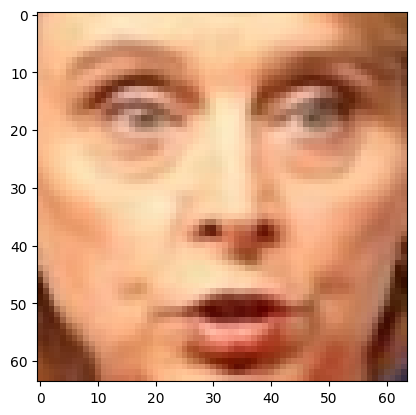

In [3]:
# Display the first image in the lfwcrop_color dataset
plt.imshow(images[0])

In [4]:
import random

# Shuffle the images and split them into 70% training, 20% validation, and 10% test sets.

random.shuffle(images)
total_imgs = len(images)


train_split = int(0.7 * total_imgs)
val_split = int(0.9 * total_imgs)


train_imgs = images[:train_split]
val_imgs = images[train_split:val_split]
test_imgs = images[val_split:]

print(f"Training set: {len(train_imgs)} images")
print(f"Validation set: {len(val_imgs)} images")
print(f"Test set: {len(test_imgs)} images")


Training set: 9263 images
Validation set: 2646 images
Test set: 1324 images


In [5]:
len(images)


13233

### 1.2: **Add Gaussian noise to the dataset**

**a.**  I created a function, 'add_gaussian_noise', to add random Gaussian noise with a mean of 0 and a standard deviation of 0.1 * 255 to the image pixels,  slightly changing their values.

**b.**  Applied this function to the training, validation, and test images to generate noisy versions of the clean images.

**c.** Used a loop to process each image, to ensure that pixel values remain within 0-255.

In [6]:
import numpy as np
import cv2
# Add Gaussian noise to the training, validation, and test images, and ensure pixel values remain within a valid range.

def add_gaussian_noise(image, mean=0, sigma=0.1 * 255):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch)) 
    noisy_image = image + gauss 
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)  
    return noisy_image


noisy_train_imgs = [add_gaussian_noise(np.array(img), cv2.COLOR_BGR2RGB) for img in train_imgs]
noisy_val_imgs = [add_gaussian_noise(np.array(img), cv2.COLOR_BGR2RGB) for img in val_imgs]
noisy_test_imgs = [add_gaussian_noise(np.array(img), cv2.COLOR_BGR2RGB) for img in test_imgs]


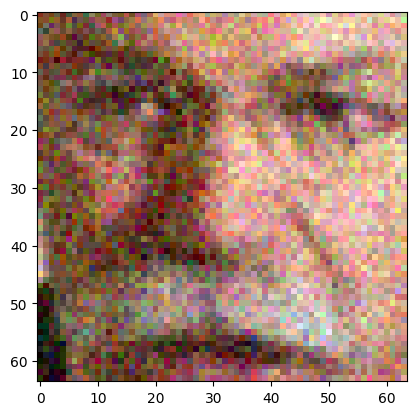

In [7]:
# a noisy image
plt.imshow(noisy_train_imgs[5])

This next step is taken to prepare the data for training.


In [8]:
# Normalize the noisy and clean training, validation, and test image data to the range [0, 1].

noisy_train_data = np.array(noisy_train_imgs) / 255.0
clean_train_data = np.array(train_imgs) / 255.0

noisy_val_data = np.array(noisy_val_imgs) / 255.0
clean_val_data = np.array(val_imgs) / 255.0

noisy_test_data = np.array(noisy_test_imgs) / 255.0
clean_test_data = np.array(test_imgs) / 255.0


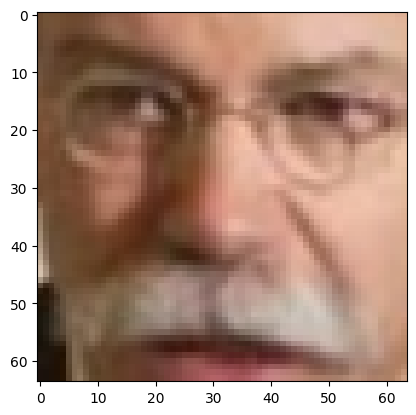

In [9]:
plt.imshow(clean_train_data[5])

### 1.3: **Build a Fully Convolutional Network (FCN) for Denoising**

This model is designed for image denoising. It begins with an encoder that compresses the image while extracting key features. It is followed by a decoder that reconstructs the image to its original resolution. 

The final layer uses a sigmoid activation to ensure the output has the appropriate pixel values for RGB images, producing a clean, denoised result.

In [61]:
def simple_denoising_model(input_shape):
    modelOphi = models.Sequential()

    # Encoder: 3 convolutional layers with pooling
    modelOphi.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    modelOphi.add(layers.MaxPooling2D((2, 2), padding='same'))

    modelOphi.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    modelOphi.add(layers.MaxPooling2D((2, 2), padding='same'))

    modelOphi.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelOphi.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Decoder: Corresponding upsampling and convolutional layers to restore the image
    modelOphi.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    modelOphi.add(layers.UpSampling2D((2, 2)))

    modelOphi.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    modelOphi.add(layers.UpSampling2D((2, 2)))

    modelOphi.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    modelOphi.add(layers.UpSampling2D((2, 2)))

    # Final output layer: 3 channels for RGB
    modelOphi.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return modelOphi


In [62]:
# setting the model's input size based on the noisy training data
input_shape = (noisy_train_data.shape[1], noisy_train_data.shape[2], noisy_train_data.shape[3])


Training the model

The model uses mean squared error (MSE) as the loss function:
MSE measures the average squared difference between the predicted pixel values and the true pixel values. It’s commonly used in regression tasks, including image denoising, where the goal is to minimize the error between the noisy image and the clean image.

In [64]:
# build, compile and train modelOphi
modelOphi = simple_denoising_model(input_shape)

modelOphi.summary()

modelOphi.compile(optimizer='adam', loss='mean_squared_error')

history = modelOphi.fit(noisy_train_data, clean_train_data,
                        epochs=15,
                        batch_size=32,
                        validation_data=(noisy_val_data, clean_val_data))


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_89 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_78             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_39 (UpSampling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_79             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_40 (UpSampling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_80             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_41 (UpSampling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0170 - val_loss: 0.0041
Epoch 2/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 4/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 12/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 

Adam optimizer is used for training the model. The loss and validation loss values are printed for each epoch, demonstrating that the model learns to minimize the error as training progresses.



### 1.4: **Visualization and evaluation**

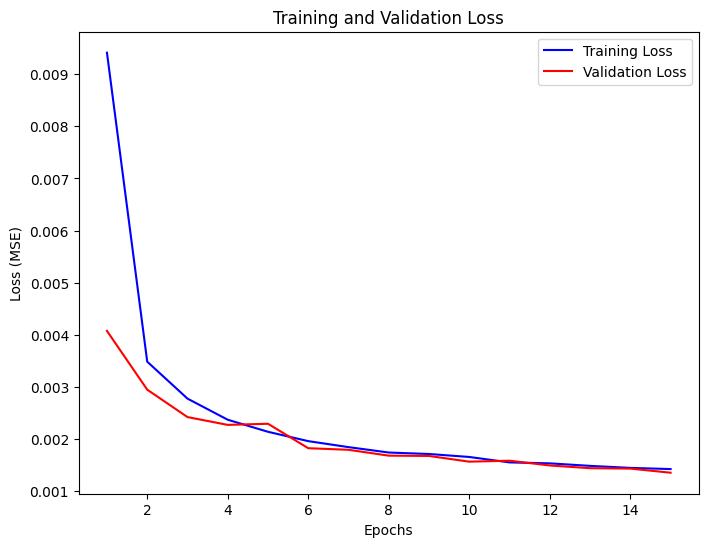

In [65]:
import matplotlib.pyplot as plt
# Get training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


The model was trained using **Mean Squared Error (MSE)** loss to reduce the difference between noisy input images and clean target images. Over 15 training rounds (epochs), the model improved continuously, with both training and validation loss decreasing. The model’s performance showed that the denoised images were of high quality. Overall, the model effectively removed noise from the images and produced results that closely matched the clean versions, and this indicates good performance.

In [66]:
# Evaluate the model on the test set
test_loss = modelOphi.evaluate(noisy_test_data, clean_test_data)
print(f"Test Loss: {test_loss}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Test Loss: 0.0013389940140768886


Calculate accuracy for the test set

In [76]:
def denoising_accuracy(y_true, y_pred, threshold = 0.1):
    return np.mean(np.abs(y_true - y_pred) < threshold)


predicted_images = modelOphi.predict(noisy_test_data)

accuracy = denoising_accuracy(clean_test_data, predicted_images)
print(f"Denoising Accuracy: {accuracy:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Denoising Accuracy: 0.9824


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


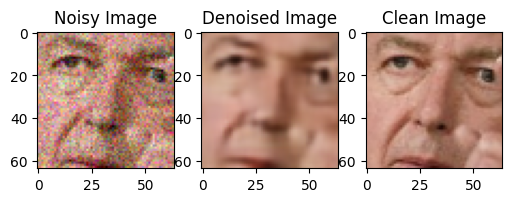

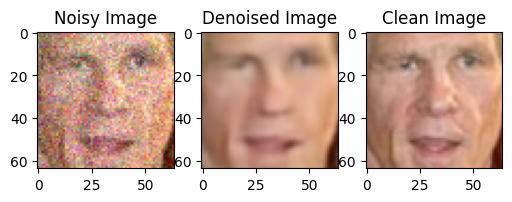

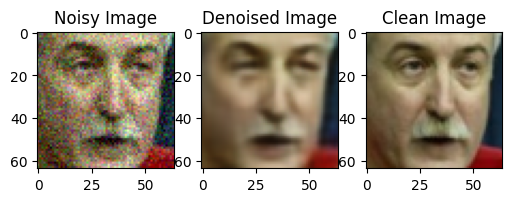

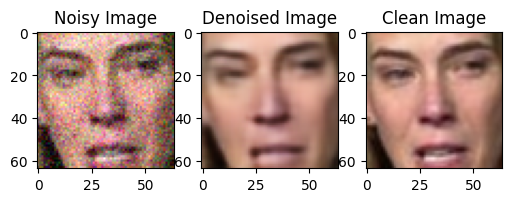

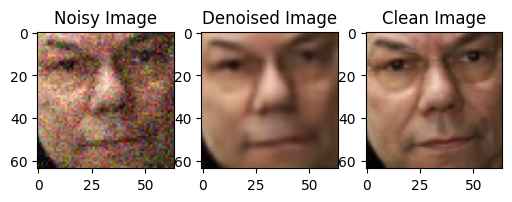

In [77]:
import matplotlib.pyplot as plt

# Predict the denoised images using the model
predicted_images = modelOphi.predict(noisy_test_data)

# Display some example results
for i in range(5):
    plt.figure(figsize=(6, 2))

    # Noisy input image
    plt.subplot(1, 3, 1)
    plt.title("Noisy Image")
    plt.imshow(noisy_test_data[i])

    # Denoised image (output from the model)
    plt.subplot(1, 3, 2)
    plt.title("Denoised Image")
    plt.imshow(predicted_images[i])

    # Ground truth clean image
    plt.subplot(1, 3, 3)
    plt.title("Clean Image")
    plt.imshow(clean_test_data[i])

    plt.show()


The test loss of **0.0013**  and accuracy of **0.9** suggests that the model is very effective at denoising images and performs well on the test data. The side-by-side comparison of noisy images, the denoised output from the model, and the clean ground truth images highlights the model’s strong ability to remove noise while keeping important facial details. The denoised images look very similar to the clean ones, showing that the model can reduce noise significantly while preserving the key features of the original images.

# 2: Evaluating an Object Detection Model

# Steps involved

1.1: **Description of the model**

1.2: **Load the SSD MobileNet v2 model**

1.3: **Run the dataset images through the SSD MobileNetV**

1.4: **mAP and evaluation**

In [6]:
!pip install tensorflow tensorflow_hub

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


###  1.1: **Description of the model**

According to ScienceDirect, MobileNetV2 is a small and fast model with 53 layers that can detect objects in images. It uses a technique called depthwise separable convolutions, which makes it more efficient by reducing the number of calculations needed. MobileNetV2 has two types of layers: one that keeps the image size the same and another that makes the image smaller, helping it run faster. This model is often used in tasks like analyzing medical images because it can work well on devices with limited processing power.  (Source: ScienceDirect, https://www.sciencedirect.com/topics/computer-science/mobilenetv2).

Even though there are more accurate models like YOLO, I chose SSD MobileNetV2 because it strikes a balance between speed and performance, and it fits the requirements of this assignment, where I need quick object detection without using too many system resources.

### 1.2: **Loading the SSD MobileNet v2 model**

In [7]:
ssd_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
ssdmodel = hub.load(ssd_url)


### 1.3: **Run the dataset images through the SSD MobileNetV**

This next code loads images from a folder and runs them through an object detection model (SSD). For each image, it checks for objects detected with a confidence score higher than 0.5. It gets the object's position (bounding box) and classifies it using the COCO labels (like "dog" or "cat"). It then draws boxes around the detected objects on the image, shows the name of the object and its score, and finally displays the image with these labels.

IMAGE: /kaggle/input/ssddata/cat.18.jpg
Displaying results for: /kaggle/input/ssddata/cat.18.jpg
Class ID: 17, Detection Score: 0.7521377801895142


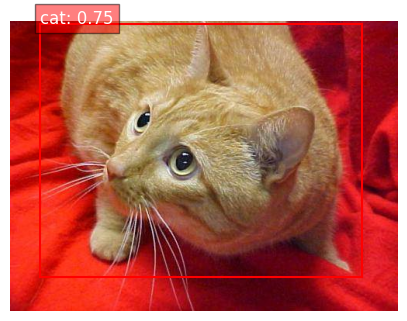

IMAGE: /kaggle/input/ssddata/dog.98.jpg
Displaying results for: /kaggle/input/ssddata/dog.98.jpg
Class ID: 18, Detection Score: 0.8077192902565002


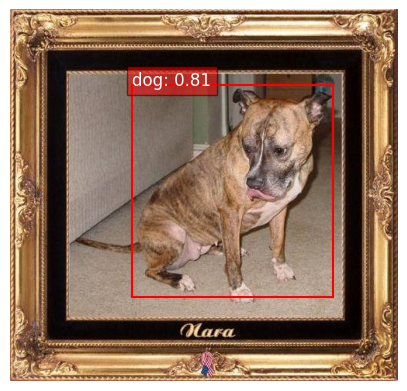

IMAGE: /kaggle/input/ssddata/dog.87.jpg
Displaying results for: /kaggle/input/ssddata/dog.87.jpg
Class ID: 18, Detection Score: 0.7853962182998657
Class ID: 62, Detection Score: 0.6163842678070068


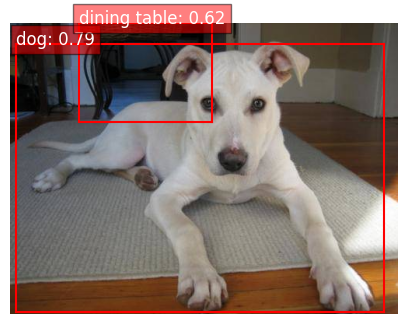

In [16]:
# COCO class labels
COCO_LABELS = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", 
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", 
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", 
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", 
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", 
    "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", 
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", 
    "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", 
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]


def display_results_with_labels(image, detection_boxes, detection_classes, detection_scores, num_detections):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)

    height, width, _ = image.shape  

    
    for i in range(num_detections):
        if detection_scores[i] >= 0.5:
            # Extract bounding box
            ymin, xmin, ymax, xmax = detection_boxes[i]
            (xmin, xmax, ymin, ymax) = (xmin * width, xmax * width, ymin * height, ymax * height)
            
            plt.plot([xmin, xmax], [ymin, ymin], color='red')  
            plt.plot([xmin, xmax], [ymax, ymax], color='red') 
            plt.plot([xmin, xmin], [ymin, ymax], color='red')  
            plt.plot([xmax, xmax], [ymin, ymax], color='red')  

       
            class_id = detection_classes[i]
            print(f"Class ID: {class_id}, Detection Score: {detection_scores[i]}")  
          
            if 1 <= class_id <= len(COCO_LABELS):
                class_name = COCO_LABELS[class_id - 1]  # Subtract 1 if the model uses 1-based indexing
            else:
                class_name = "Unknown" 

           
            plt.text(xmin, ymin, f"{class_name}: {detection_scores[i]:.2f}", color='white',
                     fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()
   
folder_path = '/kaggle/input/ssddata/'

image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]


for image_path in image_paths:
    print(f"IMAGE: {image_path}")
    
   
    image = Image.open(image_path).convert('RGB')

    # Convert the image to uint8 before passing it to the model
    image_np = np.array(image)  
    image_np_uint8 = tf.image.convert_image_dtype(image_np, dtype=tf.uint8) 
    input_tensor = tf.convert_to_tensor(image_np_uint8, dtype=tf.uint8)[tf.newaxis, ...]  

    # Run the SSD model on the image
    detections = ssdmodel(input_tensor)
    
    num_detections = int(detections['num_detections'])
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)
    detection_scores = detections['detection_scores'][0].numpy()

    
    print(f"Displaying results for: {image_path}")
    display_results_with_labels(image_np, detection_boxes, detection_classes, detection_scores, num_detections)


This code loads images, runs the SSD MobileNet model, compares the model's predictions with the ground truth labels for evaluation, and stores the predictions including bounding boxes, object classes, and confidence scores for each image.


In [17]:
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import os


gt_boxes_cat_18 = {
    'cat': [[70, 3, 430, 325]]  
}

gt_boxes_dog_87 = {
    'dog': [[38, 25, 456, 365]], 
    'dining table': [[88, 0, 255, 125]]
}

gt_boxes_dog_98 = {
    'dog': [[167, 106, 408, 378]]  
}

ground_truths = {
    'dog.98.jpg': gt_boxes_dog_98,
    'dog.87.jpg': gt_boxes_dog_87,
    'cat.18.jpg': gt_boxes_cat_18
}


for image, gt_boxes in ground_truths.items():
    print(f"Ground truths for {image}: {gt_boxes}")

# list of all image file paths in my ssddata folder(dataset)
image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]


predictions = {}


for image_path in image_paths:
    image_name = os.path.basename(image_path)
    print(f"Processing image: {image_name}")
    
    # Load and preprocess the images
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    image_np_uint8 = tf.image.convert_image_dtype(image_np, dtype=tf.uint8)
    input_tensor = tf.convert_to_tensor(image_np_uint8, dtype=tf.uint8)[tf.newaxis, ...]
    
    # Run the SSD model on the image
    detections = ssdmodel(input_tensor)
    
    # Extract the detection results
    num_detections = int(detections['num_detections'])
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)
    detection_scores = detections['detection_scores'][0].numpy()
    
    # Store the predictions for this image
    predictions[image_name] = []
    for i in range(num_detections):
        if detection_scores[i] >= 0.6:  # Filter by confidence threshold
            ymin, xmin, ymax, xmax = detection_boxes[i]
            bbox = [xmin * image_np.shape[1], ymin * image_np.shape[0], 
                    xmax * image_np.shape[1], ymax * image_np.shape[0]]
            class_id = detection_classes[i]
            class_name = COCO_LABELS[class_id-1] if class_id <= len(COCO_LABELS) else "Unknown"
            predictions[image_name].append({
                'bbox': bbox,
                'class': class_name,
                'confidence': detection_scores[i]
            })

print("Predictions collected:")
print(predictions)


Ground truths for dog.98.jpg: {'dog': [[167, 106, 408, 378]]}
Ground truths for dog.87.jpg: {'dog': [[38, 25, 456, 365]], 'dining table': [[88, 0, 255, 125]]}
Ground truths for cat.18.jpg: {'cat': [[70, 3, 430, 325]]}
Processing image: cat.18.jpg
Processing image: dog.98.jpg
Processing image: dog.87.jpg
Predictions collected:
{'cat.18.jpg': [{'bbox': [38.779109716415405, 2.823811888694763, 453.43664288520813, 329.43077290058136], 'class': 'cat', 'confidence': 0.7521378}], 'dog.98.jpg': [{'bbox': [157.23592042922974, 97.59284019470215, 416.4389371871948, 371.5019416809082], 'class': 'dog', 'confidence': 0.8077193}], 'dog.87.jpg': [{'bbox': [7.268555104732513, 27.242861688137054, 480.52688723802567, 371.63858860731125], 'class': 'dog', 'confidence': 0.7853962}, {'bbox': [88.2608977407217, 0.0, 259.77021992206573, 127.82974541187286], 'class': 'dining table', 'confidence': 0.61638427}]}


### 1.4: **mAP and evaluation**

This next code visualizes the predicted and ground truth bounding boxes on an image, computes the Intersection over Union (IoU) between predicted and actual boxes, and prints the IoU values to evaluate the accuracy of the object detection model.



Visualizing predictions for cat.18.jpg


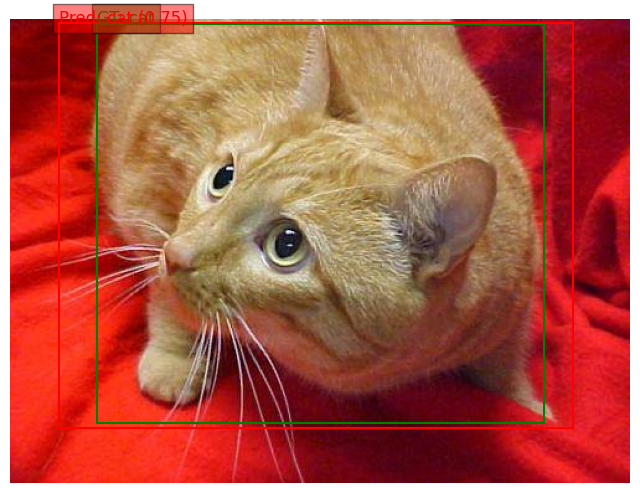

Computing IoU for cat.18.jpg:
Predicted: [38.779109716415405, 2.823811888694763, 453.43664288520813, 329.43077290058136], Ground Truth: [70, 3, 430, 325], IoU: 0.8559401057962442

Visualizing predictions for dog.98.jpg


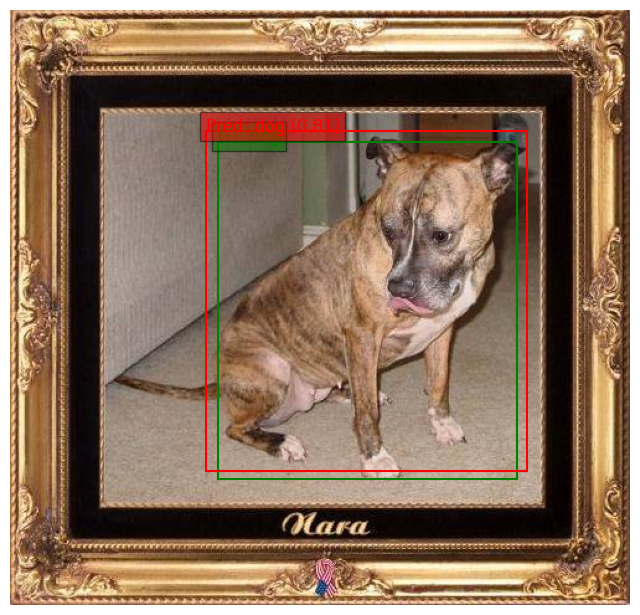

Computing IoU for dog.98.jpg:
Predicted: [157.23592042922974, 97.59284019470215, 416.4389371871948, 371.5019416809082], Ground Truth: [167, 106, 408, 378], IoU: 0.8817854857887574

Visualizing predictions for dog.87.jpg


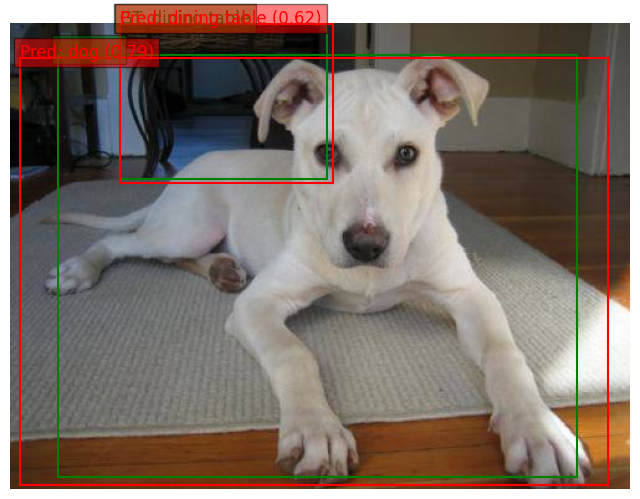

Computing IoU for dog.87.jpg:
Predicted: [7.268555104732513, 27.242861688137054, 480.52688723802567, 371.63858860731125], Ground Truth: [38, 25, 456, 365], IoU: 0.8612591878469864
Predicted: [88.2608977407217, 0.0, 259.77021992206573, 127.82974541187286], Ground Truth: [88, 0, 255, 125], IoU: 0.9492536567087801


In [18]:

def visualize_predictions(image, ground_truths, predictions):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    

    for class_name, gt_boxes in ground_truths.items():
        for gt_box in gt_boxes:
            xmin, ymin, xmax, ymax = gt_box  
            plt.plot([xmin, xmax], [ymin, ymin], color='green') 
            plt.plot([xmin, xmax], [ymax, ymax], color='green')  
            plt.plot([xmin, xmin], [ymin, ymax], color='green')  
            plt.plot([xmax, xmax], [ymin, ymax], color='green') 
            plt.text(xmin, ymin, f"GT: {class_name}", color='green', fontsize=12, 
                     bbox=dict(facecolor='green', alpha=0.5))
    
 
    for pred in predictions:
        xmin, ymin, xmax, ymax = pred['bbox']
        plt.plot([xmin, xmax], [ymin, ymin], color='red')  
        plt.plot([xmin, xmax], [ymax, ymax], color='red')  
        plt.plot([xmin, xmin], [ymin, ymax], color='red')  
        plt.plot([xmax, xmax], [ymin, ymax], color='red')
        plt.text(xmin, ymin, f"Pred: {pred['class']} ({pred['confidence']:.2f})", 
                 color='red', fontsize=12, bbox=dict(facecolor = 'red', alpha = 0.5))
    
    plt.axis('off')
    plt.show()
    
# IoU computation
def compute_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of intersection
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Compute the area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

    
for image_name in ['cat.18.jpg', 'dog.98.jpg', 'dog.87.jpg']:
    image_path = f'/kaggle/input/ssddata/{image_name}'  
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)

    print(f"\nVisualizing predictions for {image_name}")
    visualize_predictions(image_np, ground_truths[image_name], predictions[image_name])
    
    print(f"Computing IoU for {image_name}:")
    for pred in predictions[image_name]:
        for gt in ground_truths[image_name][pred['class']]:
            iou = compute_iou(pred['bbox'], gt)
            print(f"Predicted: {pred['bbox']}, Ground Truth: {gt}, IoU: {iou}")


In [19]:
len(predictions)

3

**mAP**


# **mAP (mean Average Precision)** measures how well an object detection model works by calculating the average precision for each class and then averaging them.

# **IoU (Intersection over Union)** checks how much overlap there is between the predicted box and the correct box. If IoU is higher than a set threshold (example., 0.5), it is a true positive; if not, it is a false positive.

# *Precision* shows how many of the model's positive predictions were correct:

# **$Precision = \frac{TP}{TP + FP}$**


# **Recall** shows how many actual positives were correctly found:
# $Recall = \frac{TP}{TP + FN}$

**mAP** is the average of precision values across all classes at different recall levels.


Calculating the **mean Average Precision (mAP)** by checking how well the predicted boxes match the actual (ground truth) boxes. Counting the correct matches as True Positives (TP), wrong matches as False Positives (FP), and missed boxes as False Negatives (FN). Then, it using this information to measure how accurate the predictions are and then give an overall score (mAP) to see how well the model is doing.

In [26]:
def calculate_map(ground_truths, predictions, iou_threshold = 0.5 ):
    """Calculate mean Average Precision (mAP) for the dataset."""
    all_aps = []

    for image_id, gt_data in ground_truths.items():
        if image_id not in predictions:
            continue
        
        pred_boxes = predictions[image_id]
        gt_boxes = [] 
        gt_classes = []  
        
        # Flatten ground truth boxes and class names
        for class_name, boxes in gt_data.items():
            gt_boxes.extend(boxes)
            gt_classes.extend([class_name] * len(boxes))
        
        # Initialize TP/FP for each prediction (set to zero)
        tp = np.zeros(len(pred_boxes))  
        fp = np.zeros(len(pred_boxes))  
        fn = len(gt_boxes)  
        # False Negatives are initially set to the number of ground truths      
#         A False Negative means a ground truth object that the model failed to detect. So, before comparing the predicted boxes to the ground truth boxes, 
#         the assumption is that all ground truth objects have been missed. As the predictions are checked and matches are found with the ground truth boxes, 
#         the number of False Negatives decreases. 
#         Each time a prediction correctly matches a ground truth box (True Positive), one False Negative is removed.

        matched_gt = set()
        
        # Sort predictions by confidence score
        pred_boxes = sorted(pred_boxes, key=lambda x: x['confidence'], reverse=True)
        
        for pred_idx, pred in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            
            # Compare with each ground truth box
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx in matched_gt:
                    continue  
                
                iou = compute_iou(pred['bbox'], gt_box)
                
                if iou > best_iou and pred['class'] == gt_classes[gt_idx]:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            # Apply IoU threshold to classify TP or FP
            if best_iou >= iou_threshold:
                tp[pred_idx] = 1  
                fn -= 1  
                matched_gt.add(best_gt_idx)
            else:
                fp[pred_idx] = 1 

        # Calculate precision and recall at each step
        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        recall = cum_tp / (len(gt_boxes) + 1e-6) 
        precision = cum_tp / (cum_tp + cum_fp + 1e-6)
        
        # Calculate the precision for different recall levels
        recall_levels = np.linspace(0, 1, 11)
        precisions_at_recalls = []
        
        for recall_level in recall_levels:
            precisions_at_recalls.append(np.max(precision[recall >= recall_level]) if np.any(recall >= recall_level) else 0)
        
        # Compute average precision (AP) for this image
        ap = np.mean(precisions_at_recalls)
        all_aps.append(ap)

        
        print(f"Image: {image_id}, TP: {np.sum(tp)}, FP: {np.sum(fp)}, FN: {fn}")
    return np.mean(all_aps) if all_aps else 0
map_value = calculate_map(ground_truths, predictions, iou_threshold=0.5)
print(f"mAP: {map_value}")


Image: dog.98.jpg, TP: 1.0, FP: 0.0, FN: 0
Image: dog.87.jpg, TP: 2.0, FP: 0.0, FN: 0
Image: cat.18.jpg, TP: 1.0, FP: 0.0, FN: 0
mAP: 0.9090901515158333


In [25]:
map_value = calculate_map(ground_truths, predictions, iou_threshold=0.75)
print(f"mAP with IoU=0.75: {map_value}")

map_value = calculate_map(ground_truths, predictions, iou_threshold=0.9)
print(f"mAP with IoU=0.9: {map_value}")


Image: dog.98.jpg, TP: 1.0, FP: 0.0, FN: 0
Image: dog.87.jpg, TP: 2.0, FP: 0.0, FN: 0
Image: cat.18.jpg, TP: 1.0, FP: 0.0, FN: 0
mAP with IoU=0.75: 0.9090901515158333
Image: dog.98.jpg, TP: 0.0, FP: 1.0, FN: 1
Image: dog.87.jpg, TP: 1.0, FP: 1.0, FN: 1
Image: cat.18.jpg, TP: 0.0, FP: 1.0, FN: 1
mAP with IoU=0.9: 0.07575753787880682


## The SSD model did a great job, with a high mAP of 90.9% at an IoU threshold of 0.5 and 0.7. This means the model is good at finding and placing boxes around objects. However, when the IoU threshold was raised to 0.9, the mAP reduced, and this that the model struggles with higher precision. If we set the confidence level to 0.7 or higher, the mAP will also go down because fewer predictions will be accepted. The high mAP at lower thresholds means the model is accurate, but it might also be because the dataset was easier for the model to handle.

## 3. **Training a small image captioning model**

# a)
## **Word2Vec in the Model:**
### Word2Vec is a machine learning method that takes individual words and converts them into mathematical representations (called vectors). These vectors capture the relationships between words based on how they appear together in sentences.

## **Where it is used in this model:** 
### In the caption generation model, Word2Vec is used to take the words in the captions (descriptions of the images) and convert them into vectors. The model then uses these vectors to generate new captions for other images.

## **How it is used:** 
### The Word2Vec process is applied to break down the words from the captions into vectors and feed them into the neural network, which helps the model understand which words to predict next in the sequence of a caption.

## **Why it is important:** 
### Word2Vec helps the model capture word meanings based on the context of their use, making the generated captions more meaningful and contextually accurate.



# b) 
## **Loss Function:**
### The loss function in this model is categorical cross-entropy, which is a common loss function used in models that predict categories (like words from a set vocabulary).

## **How it works:**
### During training, the model predicts a word at each step of the caption sequence. The loss function compares the predicted word to the actual word (the correct next word in the caption) and calculates the difference (or error) between them.

## **Why it’s important:**
### The loss function is crucial because it tells the model how wrong its predictions are, allowing the model to improve itself by reducing this error over time. By minimizing this loss, the model gets better at predicting the next word in the caption.



# c) 
## **BLEU Score:**
### The BLEU (Bilingual Evaluation Understudy) score is a metric used to evaluate how close a machine-generated caption is to a human-generated caption.

## **How it’s calculated**: 
### BLEU compares the words and word sequences (called n-grams) in the generated caption with the reference (actual) captions. It looks at how many of the words and sequences in the generated caption match the reference captions.

## **Why it’s used:** 
### BLEU score gives a quantitative measure of how well the generated caption matches the expected human caption.

## **Is it sufficient?:** 
### BLEU is useful but might not be enough on its own to assess the quality of captions. It measures word overlap but does not evaluate fluency or the overall creativity of the caption. A caption could score high but still sound awkward or lack originality.